In [ ]:
# Подключение Google Диска
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
#@title Вывод калибровочной конфигурации
import os
# Функция для загрузки калибровочных данных
def load_intrinsics_opencv(calib_dir, cam):
    yaml_file = os.path.join(calib_dir, 'intrinsics', f'calibration_{cam}.yaml')
    if not os.path.exists(yaml_file):
        print(f"Файл внутренних параметров {yaml_file} не найден.")
        return None, None
    fs = cv2.FileStorage(yaml_file, cv2.FILE_STORAGE_READ)
    camera_matrix = fs.getNode("camera_matrix").mat()
    dist_coeffs = fs.getNode("distortion_coefficients").mat()
    fs.release()
    return camera_matrix, dist_coeffs

def load_extrinsics_opencv(calib_dir, cam):
    yaml_file = os.path.join(calib_dir, 'extrinsics', f'calibration_{cam}_extrinsics.yaml')
    if not os.path.exists(yaml_file):
        print(f"Файл внешних параметров {yaml_file} не найден.")
        return None, None
    fs = cv2.FileStorage(yaml_file, cv2.FILE_STORAGE_READ)
    rotation_matrix = fs.getNode("rotation_matrix").mat()
    translation_vector = fs.getNode("translation_vector").mat()
    fs.release()
    return rotation_matrix, translation_vector

# Загрузка калибровочных данных
calib_dir = '/content/drive/MyDrive/Karate_2/triang_3'
cams = ['cam1', 'cam2', 'cam4']

intrinsics = {}
extrinsics = {}

for cam in cams:
    camera_matrix, dist_coeffs = load_intrinsics_opencv(calib_dir, cam)
    rotation_matrix, translation_vector = load_extrinsics_opencv(calib_dir, cam)
    intrinsics[cam] = {'camera_matrix': camera_matrix, 'dist_coeffs': dist_coeffs}
    extrinsics[cam] = {'rotation_matrix': rotation_matrix, 'translation_vector': translation_vector}

In [ ]:
intrinsics

{'cam1': {'camera_matrix': array([[2.51383283e+03, 0.00000000e+00, 1.31337399e+03],
         [0.00000000e+00, 2.49071320e+03, 5.08048986e+02],
         [0.00000000e+00, 0.00000000e+00, 1.00000000e+00]]),
  'dist_coeffs': array([[ 4.78934978e-01,  5.76955632e+00, -5.87764053e-03,
           4.05717282e-02, -7.84471007e+01]])},
 'cam2': {'camera_matrix': array([[2.51878976e+03, 0.00000000e+00, 1.08548575e+03],
         [0.00000000e+00, 2.50721644e+03, 5.47674933e+02],
         [0.00000000e+00, 0.00000000e+00, 1.00000000e+00]]),
  'dist_coeffs': array([[ 2.13204690e-01, -3.80116441e-01,  3.11225881e-04,
           4.71316699e-03, -2.39162019e+00]])},
 'cam4': {'camera_matrix': array([[1.33421977e+03, 0.00000000e+00, 9.92940940e+02],
         [0.00000000e+00, 1.33111698e+03, 5.48896195e+02],
         [0.00000000e+00, 0.00000000e+00, 1.00000000e+00]]),
  'dist_coeffs': array([[-2.94448256e-02,  8.96096431e-01,  1.07542936e-03,
          -3.36732650e-03, -2.85529189e+00]])}}

In [ ]:
extrinsics

{'cam1': {'rotation_matrix': array([[ 0.753135  , -0.65459306,  0.06554086],
         [-0.14361281, -0.26081578, -0.95464679],
         [ 0.64199925,  0.7095654 , -0.29043744]]),
  'translation_vector': array([[-0.88155621],
         [ 0.59930006],
         [ 5.57308522]])},
 'cam2': {'rotation_matrix': array([[ 0.82399295,  0.56653343,  0.00868829],
         [ 0.18721801, -0.25776187, -0.94789674],
         [-0.53477568,  0.78268684, -0.31845923]]),
  'translation_vector': array([[-1.11822831],
         [ 0.07571146],
         [ 9.60747452]])},
 'cam4': {'rotation_matrix': array([[-0.80026105,  0.59950501, -0.01326648],
         [ 0.18066465,  0.21995005, -0.95863562],
         [-0.5717889 , -0.76955553, -0.28432682]]),
  'translation_vector': array([[0.25135136],
         [0.20750131],
         [4.63070041]])}}

In [ ]:
#@title Корректировка дисторсии

import numpy as np
import cv2  # Для коррекции дисторсии

# Функция для создания проекционной матрицы
def create_projection_matrix(camera_matrix, rotation_matrix, translation_vector):
    """
    Создает проекционную матрицу P = K[R|t].
    """
    extrinsic_matrix = np.hstack((rotation_matrix, translation_vector))
    projection_matrix = camera_matrix @ extrinsic_matrix
    return projection_matrix

def undistort_points(x, y, camera_matrix, dist_coeffs):
    """
    Корректирует дисторсию для заданных координат точки.
    """
    points = np.array([[x, y]], dtype=np.float32).reshape(-1, 1, 2)
    undistorted_points = cv2.undistortPoints(points, camera_matrix, dist_coeffs, None, camera_matrix)
    return undistorted_points[0][0]  # Возвращаем скорректированные координаты (x', y')

def synchronize_data(df1, df2, df4, offset_cam2=0, offset_cam4=0):
    """
    Синхронизирует данные трех камер на основе временных сдвигов.
    """
    max_length = min(
        len(df1),
        len(df2) + abs(offset_cam2),
        len(df4) + abs(offset_cam4)
    )

    synchronized_data = {
        'cam1': df1.iloc[:max_length],
        'cam2': df2.iloc[offset_cam2:offset_cam2 + max_length] if offset_cam2 >= 0 else df2.iloc[:len(df2) + offset_cam2],
        'cam4': df4.iloc[offset_cam4:offset_cam4 + max_length] if offset_cam4 >= 0 else df4.iloc[:len(df4) + offset_cam4],
    }
    return synchronized_data

# Взвешенная триангуляция (из triangulation.txt)
def weighted_triangulation(projection_matrices, x_files, y_files, likelihood_files):
    """
    Выполняет взвешенную триангуляцию для получения начальных 3D-координат.
    """
    A = []
    for i in range(len(projection_matrices)):
        P = projection_matrices[i]
        x, y = x_files[i], y_files[i]
        w = likelihood_files[i]  # Вес (достоверность)

        if np.isnan(x) or np.isnan(y) or np.isnan(w) or w == 0:
            continue  # Пропускаем камеры с недоступными данными

        # Уравнения для триангуляции
        A.append(w * (x * P[2] - P[0]))
        A.append(w * (y * P[2] - P[1]))

    if len(A) < 4:
        return np.array([np.nan, np.nan, np.nan, np.nan])  # Недостаточно данных для триангуляции

    A = np.array(A)

    # Решение системы уравнений методом SVD
    _, _, Vt = np.linalg.svd(A)
    X = Vt[-1]  # Последняя строка Vt содержит решение

    # Нормализация однородных координат
    X = X / X[3]

    return X

# Триангуляция для каждой ключевой точки
num_keypoints = 33  # Количество ключевых точек Mediapipe Pose
frames_3d = []

# Синхронизация данных
synchronized_data = synchronize_data(df1, df2, df4, time_shift_1_2, time_shift_1_4)

# Проекционные матрицы
proj_mat1 = create_projection_matrix(intrinsics['cam1']['camera_matrix'], extrinsics['cam1']['rotation_matrix'], extrinsics['cam1']['translation_vector'])
proj_mat2 = create_projection_matrix(intrinsics['cam2']['camera_matrix'], extrinsics['cam2']['rotation_matrix'], extrinsics['cam2']['translation_vector'])
proj_mat4 = create_projection_matrix(intrinsics['cam4']['camera_matrix'], extrinsics['cam4']['rotation_matrix'], extrinsics['cam4']['translation_vector'])

projection_matrices = [proj_mat1, proj_mat2, proj_mat4]

print("Проекционные матрицы")
print(projection_matrices)

# Определение минимальной длины данных
min_length = min(
    len(synchronized_data['cam1']),
    len(synchronized_data['cam2']),
    len(synchronized_data['cam4'])
)

# Параметры дисторсии для каждой камеры
dist_coeffs1 = intrinsics['cam1']['dist_coeffs']
dist_coeffs2 = intrinsics['cam2']['dist_coeffs']
dist_coeffs4 = intrinsics['cam4']['dist_coeffs']

# Обработка только тех кадров, которые доступны для всех камер
for frame_index in range(min_length):
    frame_3d = []
    for keypoint_index in range(num_keypoints):
        # Извлечение координат точки для всех камер
        try:
            x1 = synchronized_data['cam1'].iloc[frame_index][f'x_{keypoint_index}']
            y1 = synchronized_data['cam1'].iloc[frame_index][f'y_{keypoint_index}']
            likelihood1 = synchronized_data['cam1'].iloc[frame_index][f'visibility_{keypoint_index}']

            x2 = synchronized_data['cam2'].iloc[frame_index][f'x_{keypoint_index}']
            y2 = synchronized_data['cam2'].iloc[frame_index][f'y_{keypoint_index}']
            likelihood2 = synchronized_data['cam2'].iloc[frame_index][f'visibility_{keypoint_index}']

            x4 = synchronized_data['cam4'].iloc[frame_index][f'x_{keypoint_index}']
            y4 = synchronized_data['cam4'].iloc[frame_index][f'y_{keypoint_index}']
            likelihood4 = synchronized_data['cam4'].iloc[frame_index][f'visibility_{keypoint_index}']
        except IndexError:
            print(f"Frame index {frame_index} is out of bounds for one of the cameras.")
            continue  # Пропустить текущий кадр

        # Корректировка дисторсии
        camera_matrix1 = intrinsics['cam1']['camera_matrix']
        camera_matrix2 = intrinsics['cam2']['camera_matrix']
        camera_matrix4 = intrinsics['cam4']['camera_matrix']

        x1, y1 = undistort_points(x1, y1, camera_matrix1, dist_coeffs1)
        x2, y2 = undistort_points(x2, y2, camera_matrix2, dist_coeffs2)
        x4, y4 = undistort_points(x4, y4, camera_matrix4, dist_coeffs4)

        # Координаты и достоверности
        x_files = [x1, x2, x4]
        y_files = [y1, y2, y4]
        likelihood_files = [likelihood1, likelihood2, likelihood4]

        # Взвешенная триангуляция
        point_3d = weighted_triangulation(projection_matrices, x_files, y_files, likelihood_files)
        frame_3d.append(point_3d[:3])  # Берем только первые три координаты (X, Y, Z)

    frames_3d.append(frame_3d)

# Результат: список 3D-координат для каждого кадра
frames_3d = np.array(frames_3d)

Проекционные матрицы
[array([[ 2.73644060e+03, -7.13612775e+02, -2.16694225e+02,
         5.10346026e+03],
       [-3.15312473e+01, -2.89123320e+02, -2.52530780e+03,
         4.32408487e+03],
       [ 6.41999250e-01,  7.09565401e-01, -2.90437438e-01,
         5.57308522e+00]]), array([[ 1.49497363e+03,  2.27657402e+03, -3.23798971e+02,
         7.61219468e+03],
       [ 1.76512848e+02, -2.17606846e+02, -2.55099443e+03,
         5.45159797e+03],
       [-5.34775681e-01,  7.82686840e-01, -3.18459231e-01,
         9.60747452e+00]]), array([[-1.63547672e+03,  3.57482433e+01, -3.00020139e+02,
         4.93336997e+03],
       [-7.33669731e+01, -1.29626858e+02, -1.43212206e+03,
         2.81798235e+03],
       [-5.71788897e-01, -7.69555533e-01, -2.84326818e-01,
         4.63070041e+00]])]


In [ ]:
frames_3d

array([[[-0.33399778, -0.49616337,  1.60143186],
        [-0.35255293, -0.48929828,  1.640394  ],
        [-0.3628357 , -0.47900377,  1.63829086],
        ...,
        [-0.25040538, -0.82772929, -0.05413502],
        [-0.38755894, -0.44973429, -0.13683145],
        [-0.06479471, -0.71157238,  0.00589509]],

       [[-0.31958403, -0.50726404,  1.58601336],
        [-0.33916039, -0.49993191,  1.62320468],
        [-0.3485903 , -0.49077194,  1.62278479],
        ...,
        [-0.24332987, -0.82587805, -0.05815299],
        [-0.40930109, -0.4521276 , -0.13074406],
        [-0.07498608, -0.67701876, -0.02870655]],

       [[-0.3148574 , -0.50796774,  1.58387264],
        [-0.33267573, -0.4974657 ,  1.62159466],
        [-0.34335024, -0.49184526,  1.6209943 ],
        ...,
        [-0.25112742, -0.83551442, -0.0476534 ],
        [-0.42964076, -0.47780348, -0.1057904 ],
        [-0.08494526, -0.70779388, -0.01097561]],

       ...,

       [[ 0.373728  , -0.85874483,  1.47233266],
        [ 0

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

frames_3d_1 = np.load('/content/drive/MyDrive/Karate_2/output124/frames_3d_non_dist.npy')
frames_3d_2 = np.load('/content/drive/MyDrive/Karate_2/output124/frames_3d_124_dist.npy')

<Figure size 640x480 with 0 Axes>

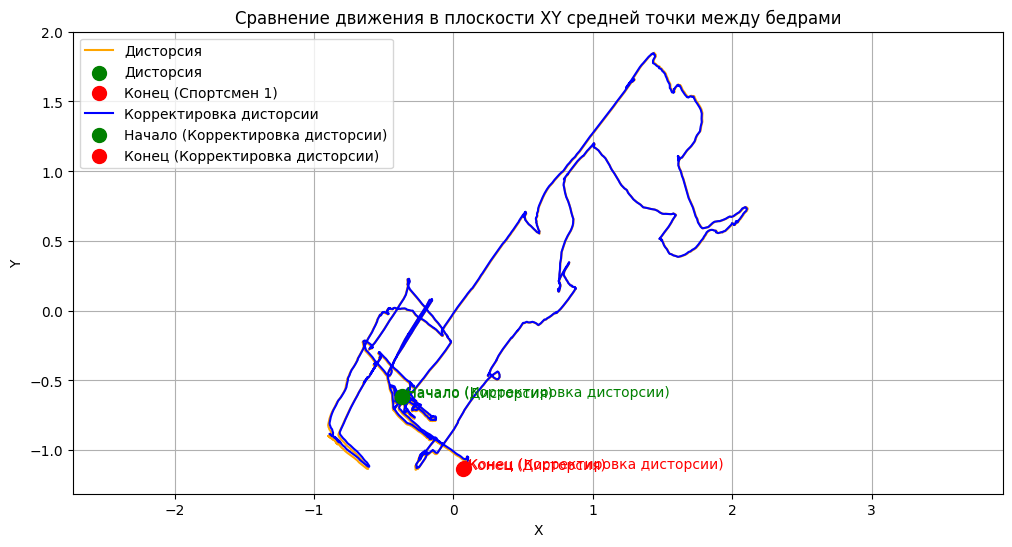

In [ ]:
# Вычисление координат X и Y средней точки между точками 23 и 24 для всех кадров (спортсмен 1)
mid_point_x_1 = (frames_3d_1[:, 23, 0] + frames_3d_1[:, 24, 0]) / 2
mid_point_y_1 = (frames_3d_1[:, 23, 1] + frames_3d_1[:, 24, 1]) / 2

# Вычисление координат X и Y средней точки между точками 23 и 24 для всех кадров (спортсмен 2)
mid_point_x_2 = (frames_3d_2[:, 23, 0] + frames_3d_2[:, 24, 0]) / 2
mid_point_y_2 = (frames_3d_2[:, 23, 1] + frames_3d_2[:, 24, 1]) / 2

# Построение графика
plt.figure(figsize=(12, 6))

# График для первого спортсмена
plt.plot(mid_point_x_1, mid_point_y_1, label="Дисторсия", color="orange")
plt.scatter(mid_point_x_1[0], mid_point_y_1[0], color="green", s=100, label="Дисторсия", zorder=5)
plt.text(mid_point_x_1[0], mid_point_y_1[0], " Начало (Дисторсия)", color="green", fontsize=10)
plt.scatter(mid_point_x_1[-1], mid_point_y_1[-1], color="red", s=100, label="Конец (Спортсмен 1)", zorder=5)
plt.text(mid_point_x_1[-1], mid_point_y_1[-1], " Конец (Дисторсия)", color="red", fontsize=10)

# График для второго спортсмена
plt.plot(mid_point_x_2, mid_point_y_2, label="Корректировка дисторсии", color="blue")
plt.scatter(mid_point_x_2[0], mid_point_y_2[0], color="green", s=100, label="Начало (Корректировка дисторсии)", zorder=5)
plt.text(mid_point_x_2[0], mid_point_y_2[0], " Начало (Корректировка дисторсии)", color="green", fontsize=10)
plt.scatter(mid_point_x_2[-1], mid_point_y_2[-1], color="red", s=100, label="Конец (Корректировка дисторсии)", zorder=5)
plt.text(mid_point_x_2[-1], mid_point_y_2[-1], " Конец (Корректировка дисторсии)", color="red", fontsize=10)

# Настройка графика
plt.title("Сравнение движения в плоскости XY средней точки между бедрами")
plt.xlabel("X")
plt.ylabel("Y")
plt.legend()
plt.grid(True)
plt.axis('equal')  # Сохранение пропорций осей

'''
# Добавление метрики расстояния между средними точками бедер
distances = np.sqrt((mid_point_x_1 - mid_point_x_2)**2 + (mid_point_y_1 - mid_point_y_2)**2)
mean_distance = np.mean(distances)
max_distance = np.max(distances)
min_distance = np.min(distances)

plt.text(0.05, 0.95, f"Среднее расстояние: {mean_distance:.2f}\nМаксимальное расстояние: {max_distance:.2f}\nМинимальное расстояние: {min_distance:.2f}",
         transform=plt.gca().transAxes, fontsize=10, verticalalignment='top', bbox=dict(boxstyle="round", facecolor="white", alpha=0.5))
'''
plt.show()

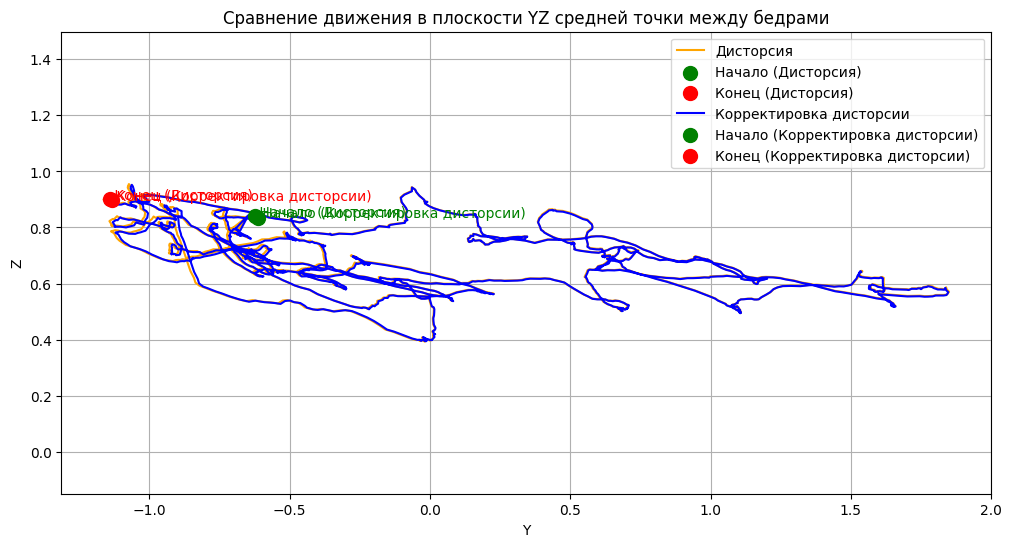

In [ ]:
# Вычисление координат Y и Z средней точки между точками 23 и 24 для всех кадров (спортсмен 1)
mid_point_y_1 = (frames_3d_1[:, 23, 1] + frames_3d_1[:, 24, 1]) / 2
mid_point_z_1 = (frames_3d_1[:, 23, 2] + frames_3d_1[:, 24, 2]) / 2

# Вычисление координат Y и Z средней точки между точками 23 и 24 для всех кадров (спортсмен 2)
mid_point_y_2 = (frames_3d_2[:, 23, 1] + frames_3d_2[:, 24, 1]) / 2
mid_point_z_2 = (frames_3d_2[:, 23, 2] + frames_3d_2[:, 24, 2]) / 2

# Построение графика
plt.figure(figsize=(12, 6))

# График для первого спортсмена
plt.plot(mid_point_y_1, mid_point_z_1, label="Дисторсия", color="orange")
plt.scatter(mid_point_y_1[0], mid_point_z_1[0], color="green", s=100, label="Начало (Дисторсия)", zorder=5)
plt.text(mid_point_y_1[0], mid_point_z_1[0], " Начало (Дисторсия)", color="green", fontsize=10)
plt.scatter(mid_point_y_1[-1], mid_point_z_1[-1], color="red", s=100, label="Конец (Дисторсия)", zorder=5)
plt.text(mid_point_y_1[-1], mid_point_z_1[-1], " Конец (Дисторсия)", color="red", fontsize=10)

# График для второго спортсмена
plt.plot(mid_point_y_2, mid_point_z_2, label="Корректировка дисторсии", color="blue")
plt.scatter(mid_point_y_2[0], mid_point_z_2[0], color="green", s=100, label="Начало (Корректировка дисторсии)", zorder=5)
plt.text(mid_point_y_2[0], mid_point_z_2[0], " Начало (Корректировка дисторсии)", color="green", fontsize=10)
plt.scatter(mid_point_y_2[-1], mid_point_z_2[-1], color="red", s=100, label="Конец (Корректировка дисторсии)", zorder=5)
plt.text(mid_point_y_2[-1], mid_point_z_2[-1], " Конец (Корректировка дисторсии)", color="red", fontsize=10)

# Настройка графика
plt.title("Сравнение движения в плоскости YZ средней точки между бедрами")
plt.xlabel("Y")
plt.ylabel("Z")
plt.legend()
plt.grid(True)
plt.axis('equal')  # Сохранение пропорций осей

plt.show()

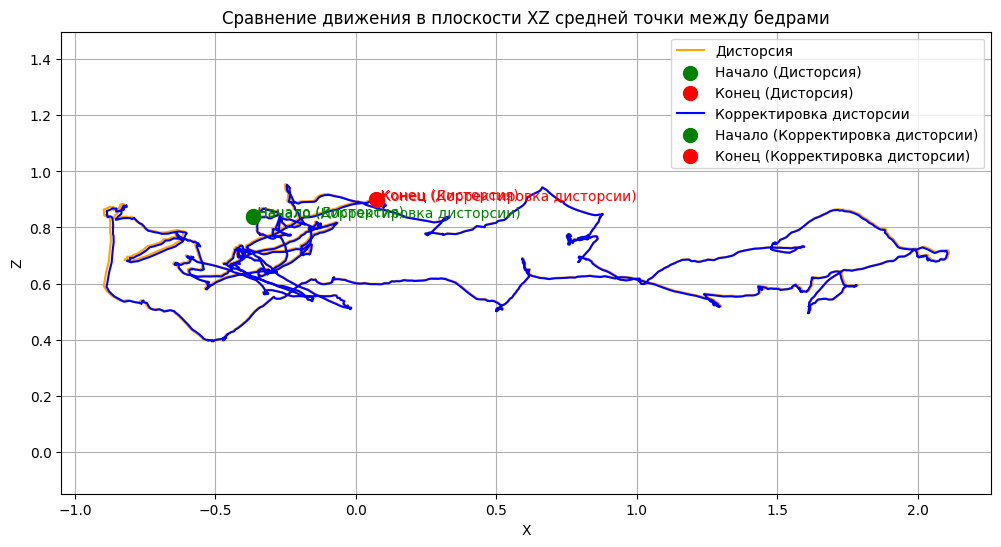

In [ ]:
# Вычисление координат X и Z средней точки между точками 23 и 24 для всех кадров (спортсмен 1)
mid_point_x_1 = (frames_3d_1[:, 23, 0] + frames_3d_1[:, 24, 0]) / 2
mid_point_z_1 = (frames_3d_1[:, 23, 2] + frames_3d_1[:, 24, 2]) / 2

# Вычисление координат X и Z средней точки между точками 23 и 24 для всех кадров (спортсмен 2)
mid_point_x_2 = (frames_3d_2[:, 23, 0] + frames_3d_2[:, 24, 0]) / 2
mid_point_z_2 = (frames_3d_2[:, 23, 2] + frames_3d_2[:, 24, 2]) / 2

# Построение графика
plt.figure(figsize=(12, 6))

# График для первого спортсмена
plt.plot(mid_point_x_1, mid_point_z_1, label="Дисторсия", color="orange")
plt.scatter(mid_point_x_1[0], mid_point_z_1[0], color="green", s=100, label="Начало (Дисторсия)", zorder=5)
plt.text(mid_point_x_1[0], mid_point_z_1[0], " Начало (Дисторсия)", color="green", fontsize=10)
plt.scatter(mid_point_x_1[-1], mid_point_z_1[-1], color="red", s=100, label="Конец (Дисторсия)", zorder=5)
plt.text(mid_point_x_1[-1], mid_point_z_1[-1], " Конец (Дисторсия)", color="red", fontsize=10)

# График для второго спортсмена
plt.plot(mid_point_x_2, mid_point_z_2, label="Корректировка дисторсии", color="blue")
plt.scatter(mid_point_x_2[0], mid_point_z_2[0], color="green", s=100, label="Начало (Корректировка дисторсии)", zorder=5)
plt.text(mid_point_x_2[0], mid_point_z_2[0], " Начало (Корректировка дисторсии)", color="green", fontsize=10)
plt.scatter(mid_point_x_2[-1], mid_point_z_2[-1], color="red", s=100, label="Конец (Корректировка дисторсии)", zorder=5)
plt.text(mid_point_x_2[-1], mid_point_z_2[-1], " Конец (Корректировка дисторсии)", color="red", fontsize=10)

# Настройка графика
plt.title("Сравнение движения в плоскости XZ средней точки между бедрами")
plt.xlabel("X")
plt.ylabel("Z")
plt.legend()
plt.grid(True)
plt.axis('equal')  # Сохранение пропорций осей

plt.show()

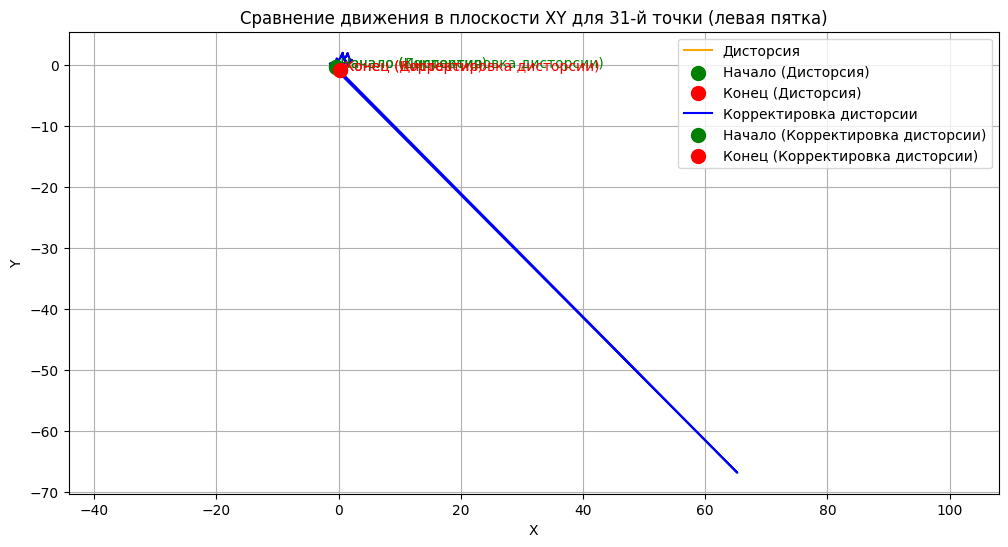

In [ ]:
# Вычисление координат X и Y для 31-й точки для всех кадров (спортсмен 1)
point_31_x_1 = frames_3d_1[:, 31, 0]
point_31_y_1 = frames_3d_1[:, 31, 1]

# Вычисление координат X и Y для 31-й точки для всех кадров (спортсмен 2)
point_31_x_2 = frames_3d_2[:, 31, 0]
point_31_y_2 = frames_3d_2[:, 31, 1]

# Построение графика
plt.figure(figsize=(12, 6))

# График для первого спортсмена
plt.plot(point_31_x_1, point_31_y_1, label="Дисторсия", color="orange")
plt.scatter(point_31_x_1[0], point_31_y_1[0], color="green", s=100, label="Начало (Дисторсия)", zorder=5)
plt.text(point_31_x_1[0], point_31_y_1[0], " Начало (Дисторсия)", color="green", fontsize=10)
plt.scatter(point_31_x_1[-1], point_31_y_1[-1], color="red", s=100, label="Конец (Дисторсия)", zorder=5)
plt.text(point_31_x_1[-1], point_31_y_1[-1], " Конец (Дисторсия)", color="red", fontsize=10)

# График для второго спортсмена
plt.plot(point_31_x_2, point_31_y_2, label="Корректировка дисторсии", color="blue")
plt.scatter(point_31_x_2[0], point_31_y_2[0], color="green", s=100, label="Начало (Корректировка дисторсии)", zorder=5)
plt.text(point_31_x_2[0], point_31_y_2[0], " Начало (Корректировка дисторсии)", color="green", fontsize=10)
plt.scatter(point_31_x_2[-1], point_31_y_2[-1], color="red", s=100, label="Конец (Корректировка дисторсии)", zorder=5)
plt.text(point_31_x_2[-1], point_31_y_2[-1], " Конец (Корректировка дисторсии)", color="red", fontsize=10)

# Настройка графика
plt.title("Сравнение движения в плоскости XY для 31-й точки (левая пятка)")
plt.xlabel("X")
plt.ylabel("Y")
plt.legend()
plt.grid(True)
plt.axis('equal')  # Сохранение пропорций осей

plt.show()

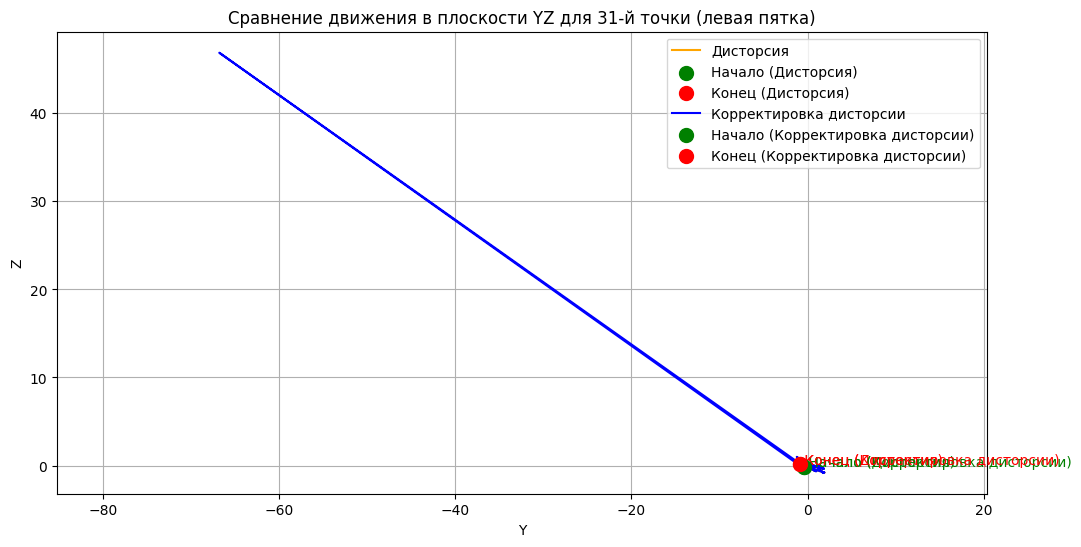

In [ ]:
# Вычисление координат Y и Z для 31-й точки для всех кадров (спортсмен 1)
point_31_y_1 = frames_3d_1[:, 31, 1]
point_31_z_1 = frames_3d_1[:, 31, 2]

# Вычисление координат Y и Z для 31-й точки для всех кадров (спортсмен 2)
point_31_y_2 = frames_3d_2[:, 31, 1]
point_31_z_2 = frames_3d_2[:, 31, 2]

# Построение графика
plt.figure(figsize=(12, 6))

# График для первого спортсмена
plt.plot(point_31_y_1, point_31_z_1, label="Дисторсия", color="orange")
plt.scatter(point_31_y_1[0], point_31_z_1[0], color="green", s=100, label="Начало (Дисторсия)", zorder=5)
plt.text(point_31_y_1[0], point_31_z_1[0], " Начало (Дисторсия)", color="green", fontsize=10)
plt.scatter(point_31_y_1[-1], point_31_z_1[-1], color="red", s=100, label="Конец (Дисторсия)", zorder=5)
plt.text(point_31_y_1[-1], point_31_z_1[-1], " Конец (Дисторсия)", color="red", fontsize=10)

# График для второго спортсмена
plt.plot(point_31_y_2, point_31_z_2, label="Корректировка дисторсии", color="blue")
plt.scatter(point_31_y_2[0], point_31_z_2[0], color="green", s=100, label="Начало (Корректировка дисторсии)", zorder=5)
plt.text(point_31_y_2[0], point_31_z_2[0], " Начало (Корректировка дисторсии)", color="green", fontsize=10)
plt.scatter(point_31_y_2[-1], point_31_z_2[-1], color="red", s=100, label="Конец (Корректировка дисторсии)", zorder=5)
plt.text(point_31_y_2[-1], point_31_z_2[-1], " Конец (Корректировка дисторсии)", color="red", fontsize=10)

# Настройка графика
plt.title("Сравнение движения в плоскости YZ для 31-й точки (левая пятка)")
plt.xlabel("Y")
plt.ylabel("Z")
plt.legend()
plt.grid(True)
plt.axis('equal')  # Сохранение пропорций осей

plt.show()

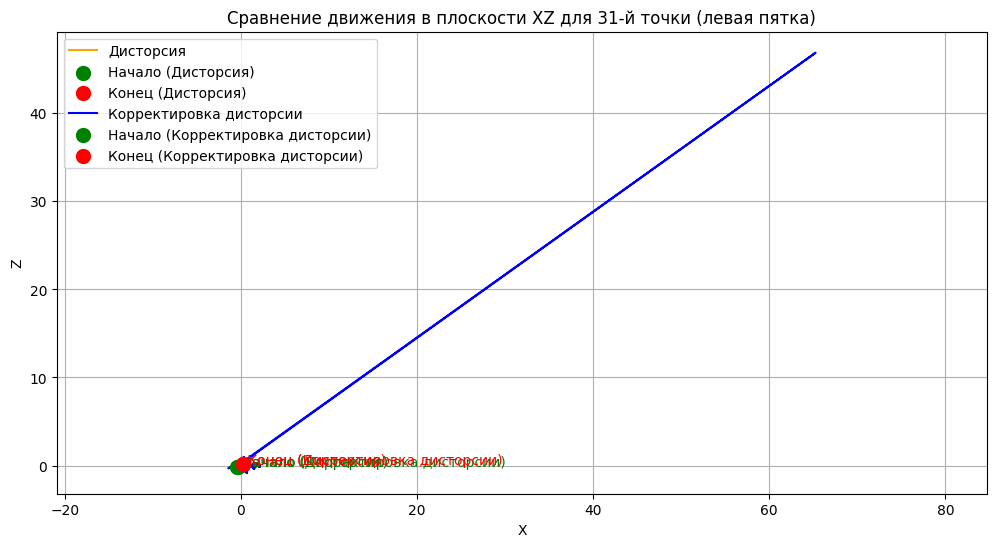

In [ ]:
# Вычисление координат X и Z для 31-й точки для всех кадров (спортсмен 1)
point_31_x_1 = frames_3d_1[:, 31, 0]
point_31_z_1 = frames_3d_1[:, 31, 2]

# Вычисление координат X и Z для 31-й точки для всех кадров (спортсмен 2)
point_31_x_2 = frames_3d_2[:, 31, 0]
point_31_z_2 = frames_3d_2[:, 31, 2]

# Построение графика
plt.figure(figsize=(12, 6))

# График для первого спортсмена
plt.plot(point_31_x_1, point_31_z_1, label="Дисторсия", color="orange")
plt.scatter(point_31_x_1[0], point_31_z_1[0], color="green", s=100, label="Начало (Дисторсия)", zorder=5)
plt.text(point_31_x_1[0], point_31_z_1[0], " Начало (Дисторсия)", color="green", fontsize=10)
plt.scatter(point_31_x_1[-1], point_31_z_1[-1], color="red", s=100, label="Конец (Дисторсия)", zorder=5)
plt.text(point_31_x_1[-1], point_31_z_1[-1], " Конец (Дисторсия)", color="red", fontsize=10)

# График для второго спортсмена
plt.plot(point_31_x_2, point_31_z_2, label="Корректировка дисторсии", color="blue")
plt.scatter(point_31_x_2[0], point_31_z_2[0], color="green", s=100, label="Начало (Корректировка дисторсии)", zorder=5)
plt.text(point_31_x_2[0], point_31_z_2[0], " Начало (Корректировка дисторсии)", color="green", fontsize=10)
plt.scatter(point_31_x_2[-1], point_31_z_2[-1], color="red", s=100, label="Конец (Корректировка дисторсии)", zorder=5)
plt.text(point_31_x_2[-1], point_31_z_2[-1], " Конец (Корректировка дисторсии)", color="red", fontsize=10)

# Настройка графика
plt.title("Сравнение движения в плоскости XZ для 31-й точки (левая пятка)")
plt.xlabel("X")
plt.ylabel("Z")
plt.legend()
plt.grid(True)
plt.axis('equal')  # Сохранение пропорций осей

plt.show()

Средняя разница для каждой ключевой точки (X, Y, Z):
Точка 0: [0.00582088 0.0063416  0.00984456]
Точка 1: [0.00612838 0.00654717 0.01068924]
Точка 2: [0.00616767 0.00656302 0.01073136]
Точка 3: [0.00620618 0.00658096 0.01076821]
Точка 4: [0.00609721 0.00655734 0.01063667]
Точка 5: [0.00610958 0.00657565 0.01063689]
Точка 6: [0.00612267 0.00659868 0.01063483]
Точка 7: [0.00638153 0.00662715 0.01055317]
Точка 8: [0.00623176 0.00666886 0.01033812]
Точка 9: [0.00572419 0.00620576 0.00919095]
Точка 10: [0.00568614 0.00624646 0.00911358]
Точка 11: [0.00583553 0.0059193  0.0072485 ]
Точка 12: [0.00534129 0.00664931 0.00658575]
Точка 13: [0.00410708 0.00413755 0.00392432]
Точка 14: [0.00482096 0.006538   0.00459602]
Точка 15: [0.00407726 0.00491528 0.00419802]
Точка 16: [0.00490798 0.00674824 0.00539326]
Точка 17: [0.00489797 0.00527946 0.00443613]
Точка 18: [0.00510338 0.00707191 0.00572232]
Точка 19: [0.00497218 0.00541901 0.00463969]
Точка 20: [0.00519417 0.00708501 0.00589772]
Точка 21: [0

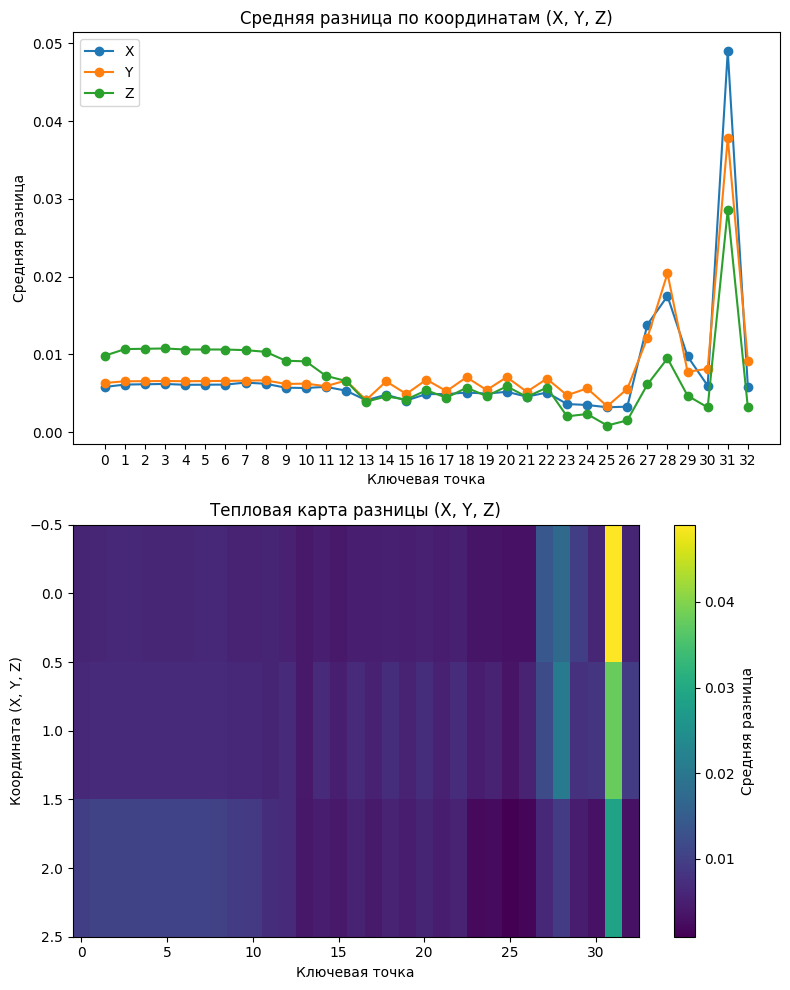

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Загрузка данных
frames_3d_1 = np.load('/content/drive/MyDrive/Karate_2/output124/frames_3d_non_dist.npy')  # Без коррекции дисторсии
frames_3d_2 = np.load('/content/drive/MyDrive/Karate_2/output124/frames_3d_124_dist.npy')  # С коррекцией дисторсии

# Проверка размеров массивов
if frames_3d_1.shape != frames_3d_2.shape:
    raise ValueError("Массивы имеют разные размеры!")

# Вычисление разницы между координатами
difference = np.abs(frames_3d_1 - frames_3d_2)

# Средняя разница для каждой ключевой точки по всем кадрам
mean_difference_per_keypoint = np.nanmean(difference, axis=0)  # Усреднение по кадрам (остаются ключевые точки и координаты)

# Вывод результатов
print("Средняя разница для каждой ключевой точки (X, Y, Z):")
for i, mean_diff in enumerate(mean_difference_per_keypoint):
    print(f"Точка {i}: {mean_diff}")

# Визуализация разницы
plt.figure(figsize=(8, 10))  # Изменяем размер фигуры для вертикального расположения

# График средней разницы по всем точкам
plt.subplot(2, 1, 1)  # Две строки, один столбец, первый график
x = np.arange(len(mean_difference_per_keypoint))  # Индексы ключевых точек
plt.plot(x, mean_difference_per_keypoint[:, 0], label="X", marker='o')
plt.plot(x, mean_difference_per_keypoint[:, 1], label="Y", marker='o')
plt.plot(x, mean_difference_per_keypoint[:, 2], label="Z", marker='o')

# Добавление промежуточных осей
plt.xticks(ticks=x, labels=[str(i) for i in x])  # Явное указание меток для ключевых точек
plt.title("Средняя разница по координатам (X, Y, Z)")
plt.xlabel("Ключевая точка")
plt.ylabel("Средняя разница")
plt.legend()

# Тепловая карта разницы
plt.subplot(2, 1, 2)  # Две строки, один столбец, второй график
heatmap = mean_difference_per_keypoint  # Уже содержит среднюю разницу для каждой точки (num_keypoints x 3)
plt.imshow(heatmap.T, cmap='viridis', aspect='auto')
plt.colorbar(label="Средняя разница")
plt.title("Тепловая карта разницы (X, Y, Z)")
plt.xlabel("Ключевая точка")
plt.ylabel("Координата (X, Y, Z)")

plt.tight_layout()
plt.show()

Кадры с наибольшим изменением:
Кадр 127: Общее изменение 2.422338
Кадр 838: Общее изменение 2.556710
Кадр 948: Общее изменение 2.778705
Кадр 944: Общее изменение 6.253075
Кадр 950: Общее изменение 6.344441
Кадр 824: Общее изменение 6.351415
Кадр 837: Общее изменение 14.410837
Кадр 946: Общее изменение 14.795481
Кадр 949: Общее изменение 25.421740
Кадр 826: Общее изменение 109.501104

Анализ кадра 127:
Среднее изменение по координатам (X, Y, Z): [0.04143318 0.06012512 0.00171476]
Наибольшее изменение происходит по координате Y.

Анализ кадра 838:
Среднее изменение по координатам (X, Y, Z): [0.0559305  0.04296348 0.02989823]
Наибольшее изменение происходит по координате X.

Анализ кадра 948:
Среднее изменение по координатам (X, Y, Z): [0.0463416  0.0620955  0.02992047]
Наибольшее изменение происходит по координате Y.

Анализ кадра 944:
Среднее изменение по координатам (X, Y, Z): [0.13043295 0.12078805 0.06303176]
Наибольшее изменение происходит по координате X.

Анализ кадра 950:
Среднее

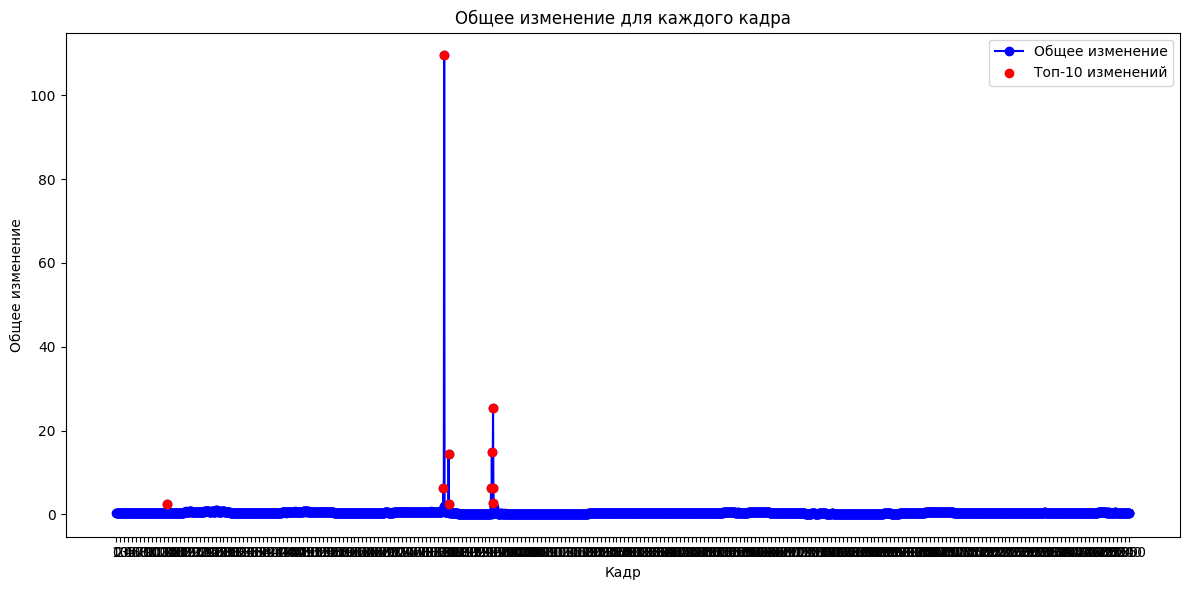

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Загрузка данных
frames_3d_1 = np.load('/content/drive/MyDrive/Karate_2/output124/frames_3d_non_dist.npy')  # Без коррекции дисторсии
frames_3d_2 = np.load('/content/drive/MyDrive/Karate_2/output124/frames_3d_124_dist.npy')  # С коррекцией дисторсии

# Проверка размеров массивов
if frames_3d_1.shape != frames_3d_2.shape:
    raise ValueError("Массивы имеют разные размеры!")

# Вычисление разницы между координатами
difference = np.abs(frames_3d_1 - frames_3d_2)

# Приведенное изменение в пространстве (евклидова норма)
euclidean_change_per_keypoint = np.sqrt(np.nansum(difference**2, axis=2))  # (num_frames, num_keypoints)

# Общее изменение для каждого кадра
total_change_per_frame = np.nansum(euclidean_change_per_keypoint, axis=1)  # (num_frames,)

# Выбор 10 кадров с наибольшим изменением
top_n = 10
top_indices = np.argsort(total_change_per_frame)[-top_n:]  # Индексы кадров с наибольшим изменением
top_changes = total_change_per_frame[top_indices]  # Значения изменений для этих кадров

print(f"Кадры с наибольшим изменением:")
for i, idx in enumerate(top_indices):
    print(f"Кадр {idx}: Общее изменение {top_changes[i]:.6f}")

# Анализ изменений по координатам для выбранных кадров
for idx in top_indices:
    print(f"\nАнализ кадра {idx}:")
    frame_difference = difference[idx]  # Разница для данного кадра
    mean_change_per_coordinate = np.nanmean(frame_difference, axis=0)  # Среднее изменение по координатам (X, Y, Z)

    print(f"Среднее изменение по координатам (X, Y, Z): {mean_change_per_coordinate}")
    if mean_change_per_coordinate[0] > mean_change_per_coordinate[1] and mean_change_per_coordinate[0] > mean_change_per_coordinate[2]:
        print("Наибольшее изменение происходит по координате X.")
    elif mean_change_per_coordinate[1] > mean_change_per_coordinate[0] and mean_change_per_coordinate[1] > mean_change_per_coordinate[2]:
        print("Наибольшее изменение происходит по координате Y.")
    else:
        print("Наибольшее изменение происходит по координате Z.")

# Визуализация
plt.figure(figsize=(12, 6))

# График общего изменения для каждого кадра
plt.subplot(1, 1, 1)
x = np.arange(len(total_change_per_frame))  # Индексы кадров
plt.plot(x, total_change_per_frame, label="Общее изменение", marker='o', color='blue')
plt.scatter(top_indices, total_change_per_frame[top_indices], color='red', label=f"Топ-{top_n} изменений", zorder=5)

# Добавление меток осей
plt.xticks(ticks=x[::10], labels=[str(i) for i in x[::10]])  # Отображаем каждую 10-ю метку для читаемости
plt.title("Общее изменение для каждого кадра")
plt.xlabel("Кадр")
plt.ylabel("Общее изменение")
plt.legend()

plt.tight_layout()
plt.show()

In [ ]:
import numpy as np

# Загрузка данных
frames_3d_1 = np.load('/content/drive/MyDrive/Karate_2/output124/frames_3d_non_dist.npy')  # Без коррекции дисторсии
frames_3d_2 = np.load('/content/drive/MyDrive/Karate_2/output124/frames_3d_124_dist.npy')  # С коррекцией дисторсии

# Проверка размеров массивов
if frames_3d_1.shape != frames_3d_2.shape:
    raise ValueError("Массивы имеют разные размеры!")

# Вычисление разницы между координатами
difference = frames_3d_1 - frames_3d_2  # Разница (до - после)

# Кадры с наибольшим изменением
top_frames = [127, 838, 948, 944, 950, 824, 837, 946, 949, 826]

# Анализ изменений для каждого кадра
for frame_idx in top_frames:
    print(f"\nАнализ кадра {frame_idx}:")
    frame_diff = difference[frame_idx]  # Разница для данного кадра

    # Анализ для каждой ключевой точки
    for keypoint_idx, keypoint_diff in enumerate(frame_diff):
        x_diff, y_diff, z_diff = keypoint_diff

        # Вывод изменений для каждой координаты
        print(f"Точка {keypoint_idx}:")
        if x_diff > 0:
            print(f"  X: Увеличение на {x_diff:.6f}")
        elif x_diff < 0:
            print(f"  X: Уменьшение на {-x_diff:.6f}")
        else:
            print("  X: Нет изменений")

        if y_diff > 0:
            print(f"  Y: Увеличение на {y_diff:.6f}")
        elif y_diff < 0:
            print(f"  Y: Уменьшение на {-y_diff:.6f}")
        else:
            print("  Y: Нет изменений")

        if z_diff > 0:
            print(f"  Z: Увеличение на {z_diff:.6f}")
        elif z_diff < 0:
            print(f"  Z: Уменьшение на {-z_diff:.6f}")
        else:
            print("  Z: Нет изменений")


Анализ кадра 127:
Точка 0:
  X: Увеличение на 0.099271
  Y: Увеличение на 0.146334
  Z: Увеличение на 0.001267
Точка 1:
  X: Увеличение на 0.131095
  Y: Увеличение на 0.193726
  Z: Уменьшение на 0.000751
Точка 2:
  X: Увеличение на 0.133947
  Y: Увеличение на 0.199119
  Z: Уменьшение на 0.001255
Точка 3:
  X: Увеличение на 0.131286
  Y: Увеличение на 0.196324
  Z: Уменьшение на 0.001159
Точка 4:
  X: Увеличение на 0.130518
  Y: Увеличение на 0.189841
  Z: Уменьшение на 0.000165
Точка 5:
  X: Увеличение на 0.129455
  Y: Увеличение на 0.187391
  Z: Увеличение на 0.000092
Точка 6:
  X: Увеличение на 0.128493
  Y: Увеличение на 0.185072
  Z: Увеличение на 0.000235
Точка 7:
  X: Увеличение на 0.089636
  Y: Увеличение на 0.136488
  Z: Увеличение на 0.003027
Точка 8:
  X: Увеличение на 0.114913
  Y: Увеличение на 0.164877
  Z: Уменьшение на 0.000228
Точка 9:
  X: Увеличение на 0.076695
  Y: Увеличение на 0.114786
  Z: Увеличение на 0.002428
Точка 10:
  X: Увеличение на 0.078690
  Y: Увеличен

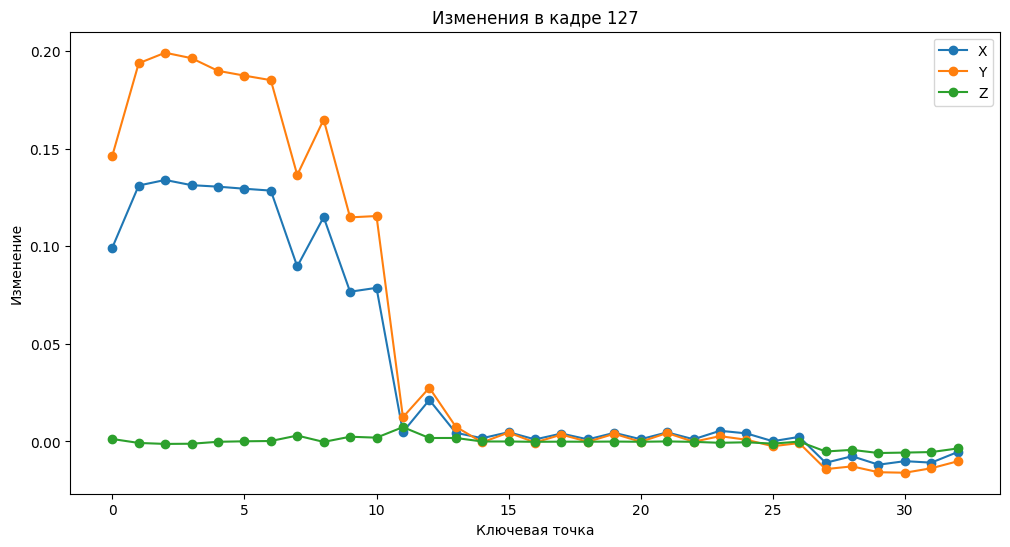

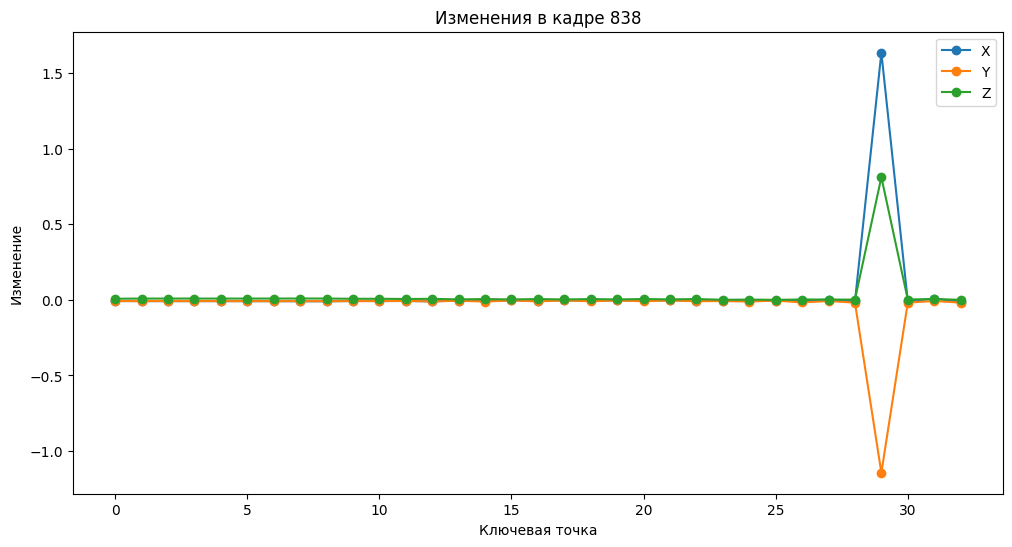

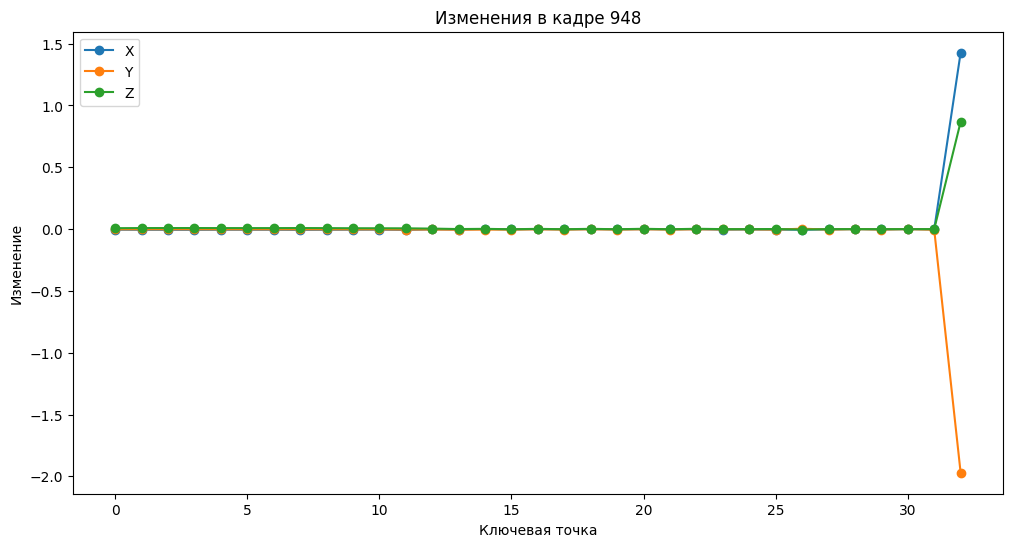

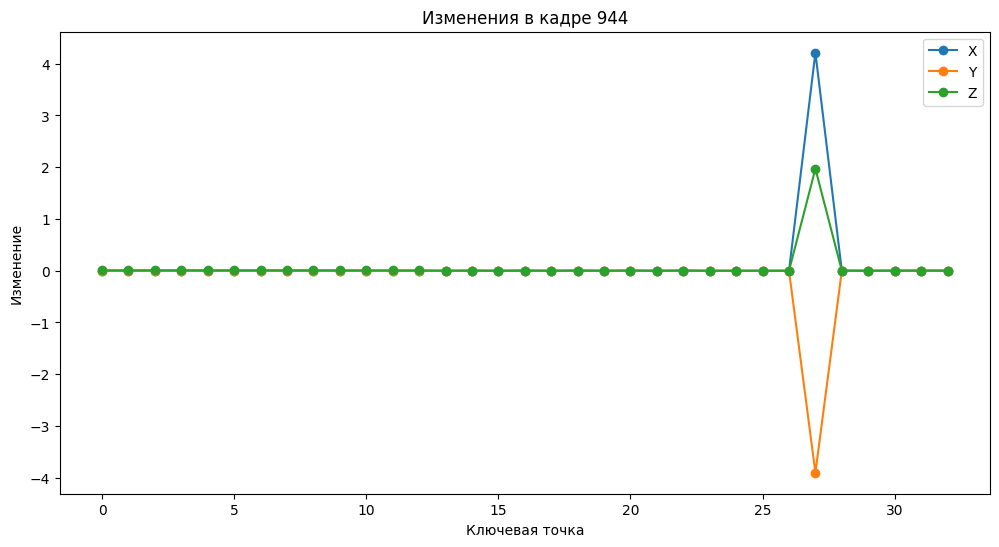

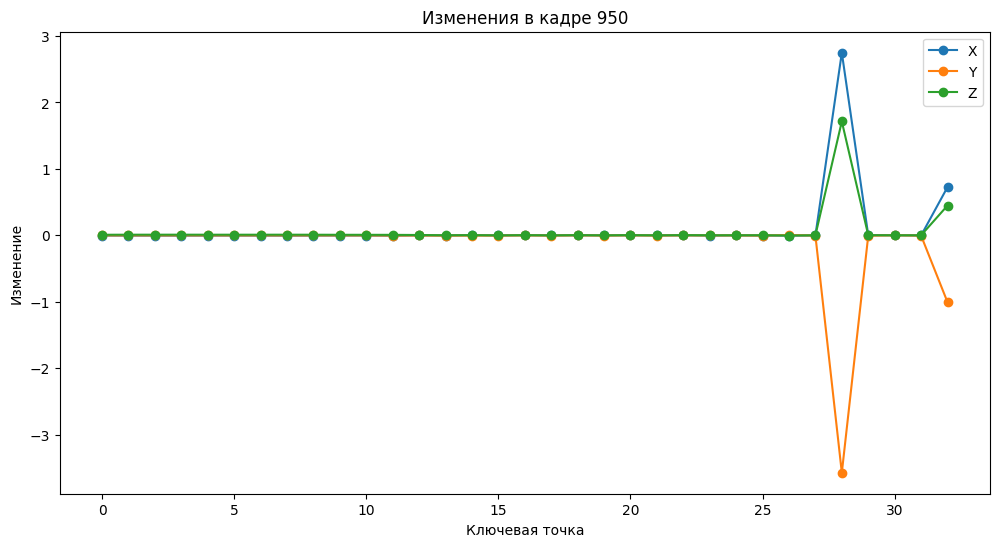

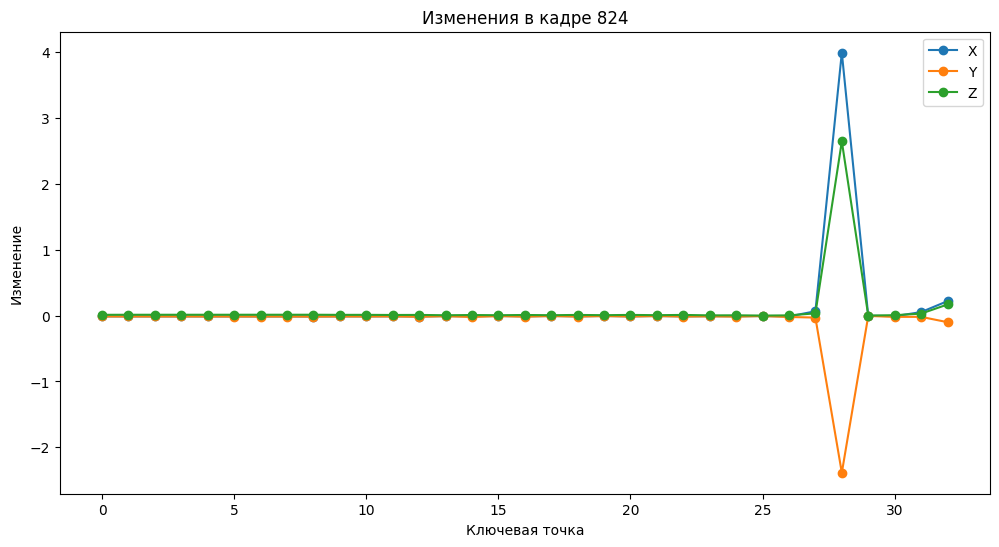

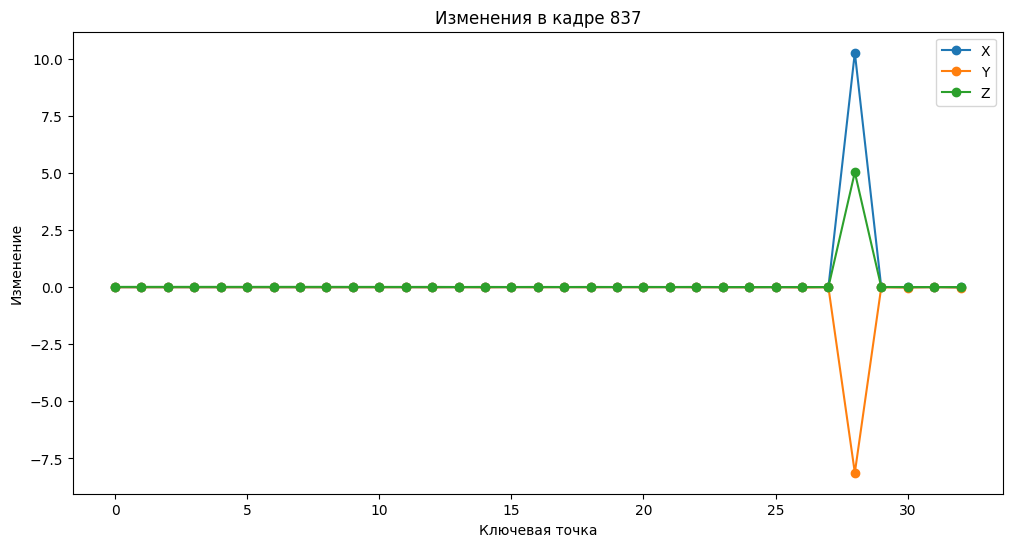

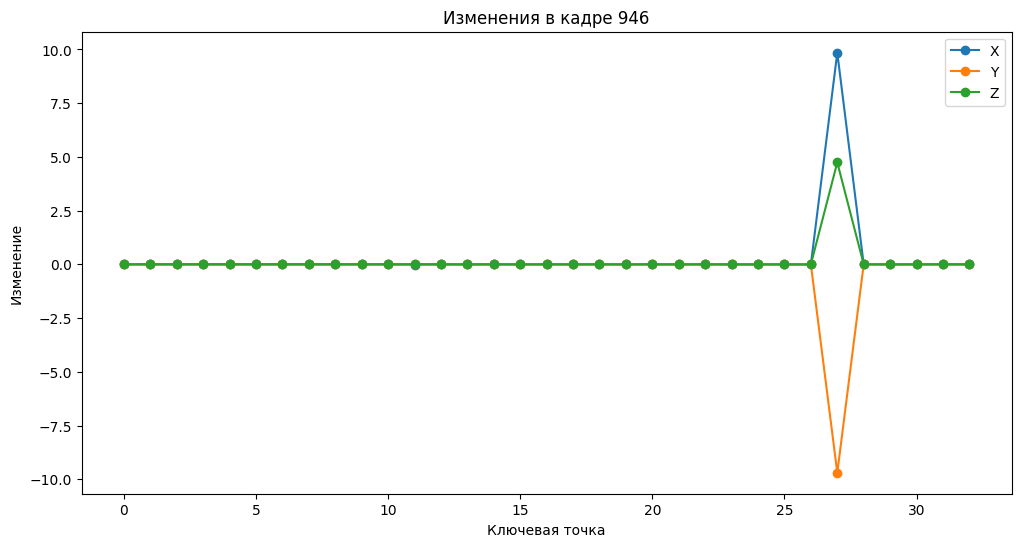

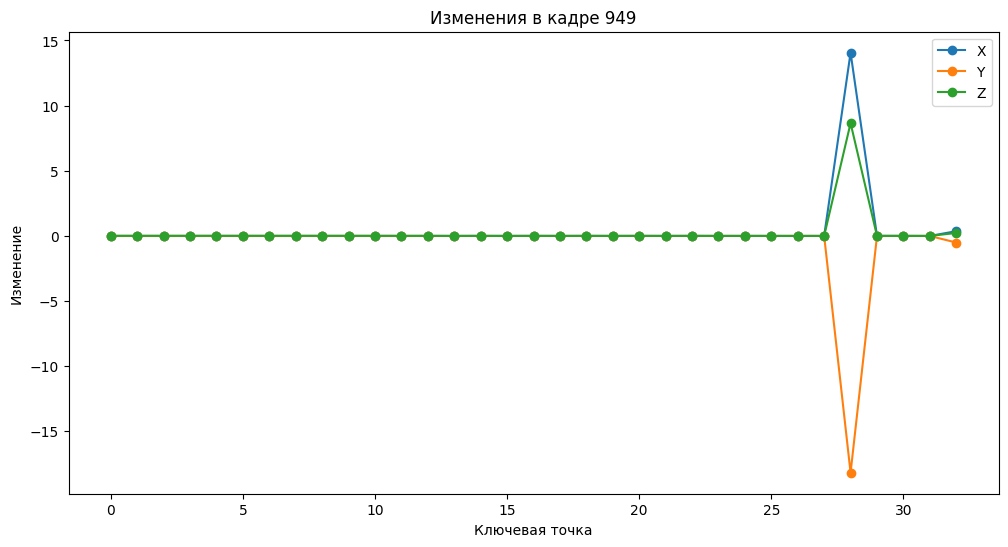

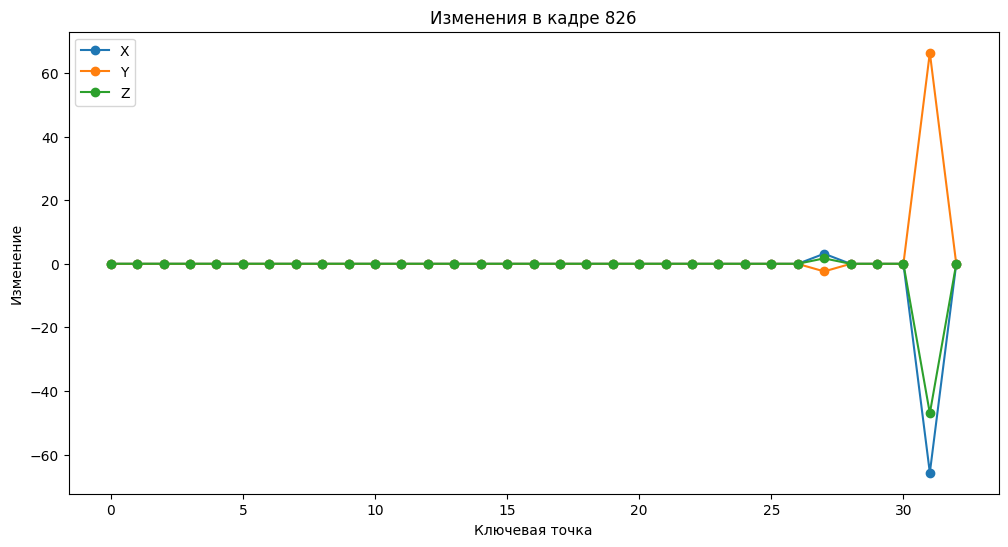

In [ ]:
import matplotlib.pyplot as plt

for frame_idx in top_frames:
    frame_diff = difference[frame_idx]
    plt.figure(figsize=(12, 6))
    plt.plot(frame_diff[:, 0], label="X", marker='o')
    plt.plot(frame_diff[:, 1], label="Y", marker='o')
    plt.plot(frame_diff[:, 2], label="Z", marker='o')
    plt.title(f"Изменения в кадре {frame_idx}")
    plt.xlabel("Ключевая точка")
    plt.ylabel("Изменение")
    plt.legend()
    plt.show()

In [ ]:
mean_x_diff = np.mean(frame_diff[:, 0])
mean_y_diff = np.mean(frame_diff[:, 1])
mean_z_diff = np.mean(frame_diff[:, 2])
print(f"Среднее изменение: X={mean_x_diff:.6f}, Y={mean_y_diff:.6f}, Z={mean_z_diff:.6f}")

Среднее изменение: X=-1.905222, Y=1.927317, Z=-1.366267


In [ ]:
'''
Ключевые точки MediaPipe Pose
Точка 0 : Нос (Nose)
Точка 1 : Левый глаз (внутренний угол) (Left Eye Inner)
Точка 2 : Левый глаз (центр) (Left Eye)
Точка 3 : Левый глаз (внешний угол) (Left Eye Outer)
Точка 4 : Правый глаз (внутренний угол) (Right Eye Inner)
Точка 5 : Правый глаз (центр) (Right Eye)
Точка 6 : Правый глаз (внешний угол) (Right Eye Outer)
Точка 7 : Левое ухо (Left Ear)
Точка 8 : Правое ухо (Right Ear)
Точка 9 : Рот (левый угол) (Mouth Left)
Точка 10 : Рот (правый угол) (Mouth Right)
Точка 11 : Левое плечо (Left Shoulder)
Точка 12 : Правое плечо (Right Shoulder)
Точка 13 : Левый локоть (Left Elbow)
Точка 14 : Правый локоть (Right Elbow)
Точка 15 : Левое запястье (Left Wrist)
Точка 16 : Правое запястье (Right Wrist)
Точка 17 : Левая рука (кончик большого пальца) (Left Pinky)
Точка 18 : Правая рука (кончик большого пальца) (Right Pinky)
Точка 19 : Левая рука (кончик указательного пальца) (Left Index)
Точка 20 : Правая рука (кончик указательного пальца) (Right Index)
Точка 21 : Левая рука (кончик среднего пальца) (Left Thumb)
Точка 22 : Правая рука (кончик среднего пальца) (Right Thumb)
Точка 23 : Левое бедро (Left Hip)
Точка 24 : Правое бедро (Right Hip)
Точка 25 : Левое колено (Left Knee)
Точка 26 : Правое колено (Right Knee)
Точка 27 : Левая лодыжка (Left Ankle)
Точка 28 : Правая лодыжка (Right Ankle)
Точка 29 : Левая стопа (пятка) (Left Heel)
Точка 30 : Правая стопа (пятка) (Right Heel)
Точка 31 : Левая стопа (кончик пальцев) (Left Foot Index)
Точка 32 : Правая стопа (кончик пальцев) (Right Foot Index)
'''

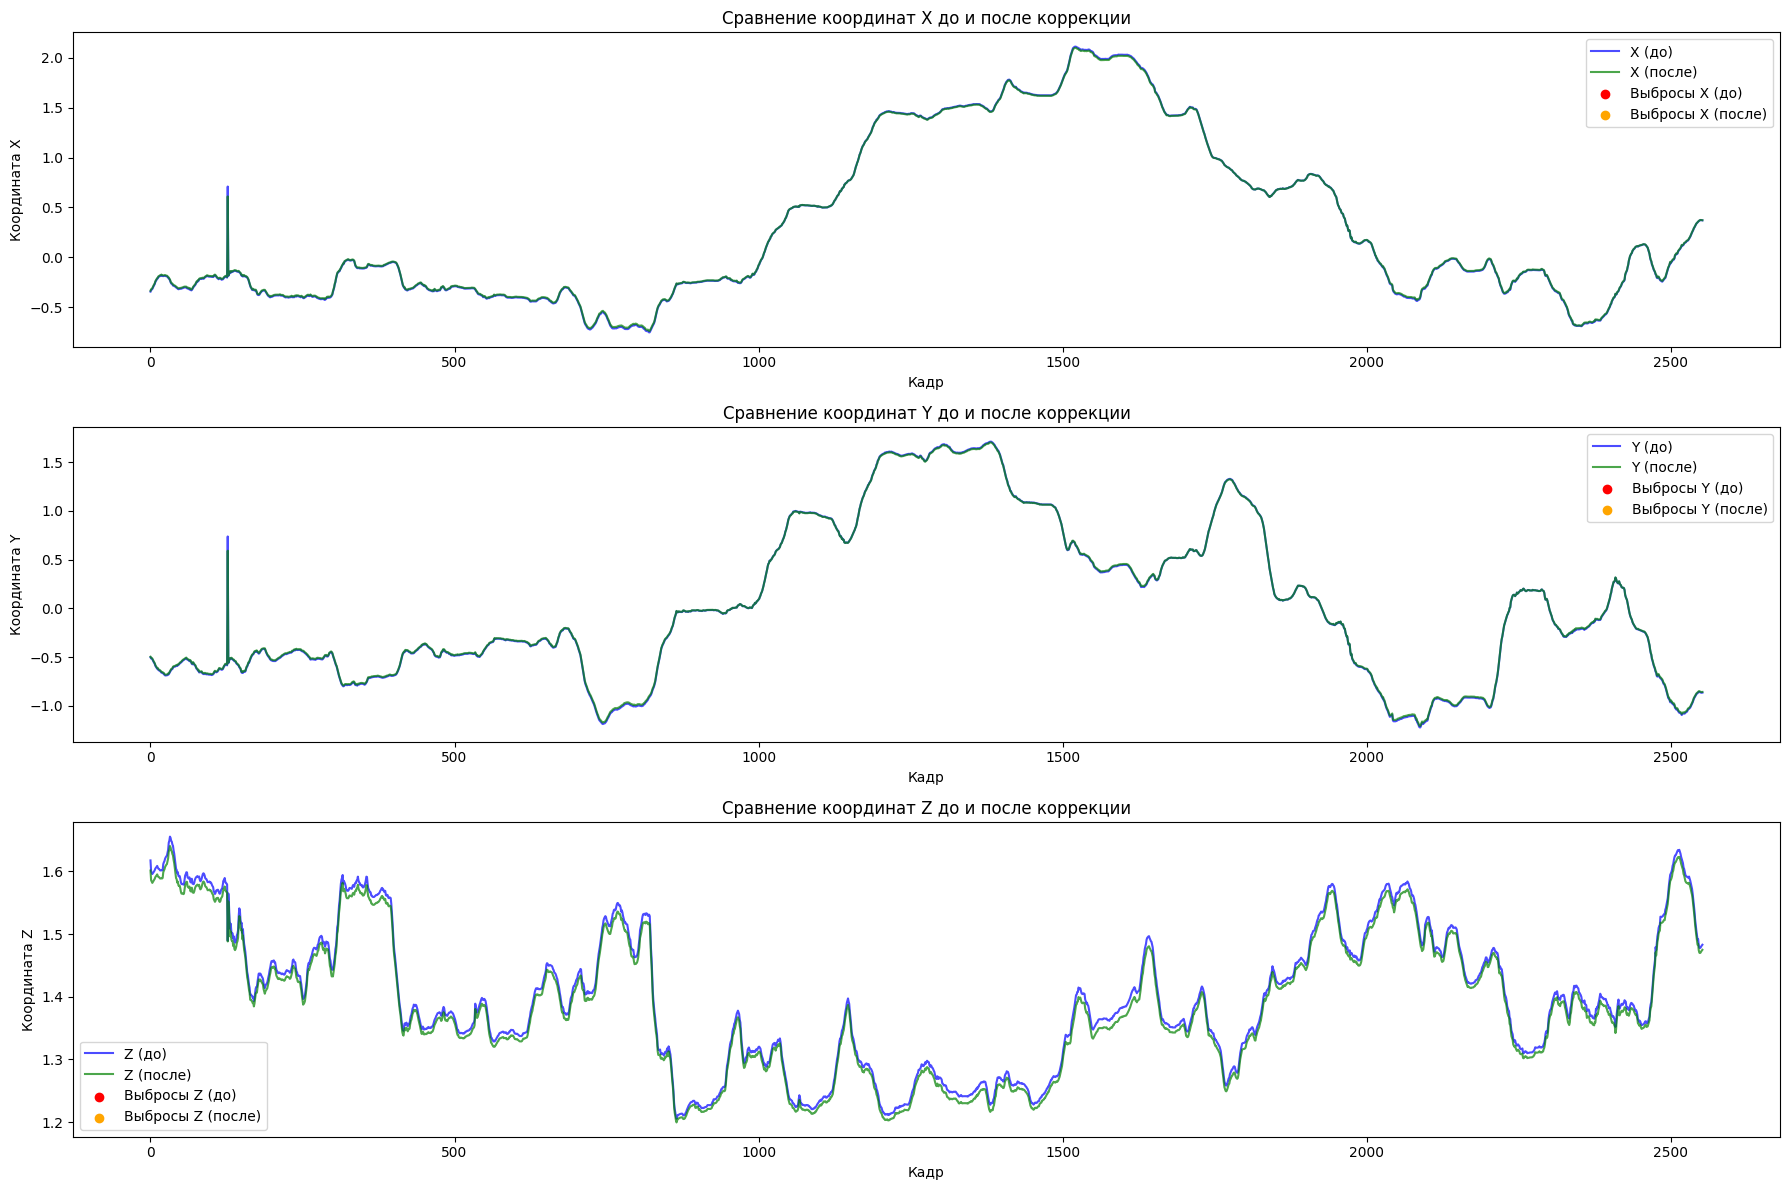

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Функция для выявления выбросов с помощью IQR
def detect_outliers(data):
    q1 = np.nanpercentile(data, 25, axis=0)
    q3 = np.nanpercentile(data, 75, axis=0)
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    return (data < lower_bound) | (data > upper_bound)

# Выявление выбросов до и после коррекции
outliers_before = detect_outliers(frames_3d_1)
outliers_after = detect_outliers(frames_3d_2)

# Визуализация
plt.figure(figsize=(18, 12))  # Увеличиваем размер фигуры под три графика

# Для каждой координаты (X, Y, Z)
for coord_index, coord_name in enumerate(["X", "Y", "Z"]):
    plt.subplot(3, 1, coord_index + 1)  # Три строки, один столбец
    keypoint_index = 0  # Например, Точка 0

    # Наложение графиков
    plt.plot(frames_3d_1[:, keypoint_index, coord_index], label=f"{coord_name} (до)", color='blue', alpha=0.7)
    plt.plot(frames_3d_2[:, keypoint_index, coord_index], label=f"{coord_name} (после)", color='green', alpha=0.7)

    # Выделение выбросов
    plt.scatter(
        np.where(outliers_before[:, keypoint_index, coord_index])[0],
        frames_3d_1[outliers_before[:, keypoint_index, coord_index], keypoint_index, coord_index],
        color='red', label=f"Выбросы {coord_name} (до)", zorder=5
    )
    plt.scatter(
        np.where(outliers_after[:, keypoint_index, coord_index])[0],
        frames_3d_2[outliers_after[:, keypoint_index, coord_index], keypoint_index, coord_index],
        color='orange', label=f"Выбросы {coord_name} (после)", zorder=5
    )

    # Настройка графика
    plt.title(f"Сравнение координат {coord_name} до и после коррекции")
    plt.xlabel("Кадр")
    plt.ylabel(f"Координата {coord_name}")
    plt.legend()

plt.tight_layout()
plt.show()